# Day 7 – Session 2: Debugging and Parameter Tuning

**Overview**: In this session, students debug the vision-to-simulation pipeline. We print intermediate values, plot intermediate results, and experiment with tuning the HSV thresholds. By visualizing the mask and contours for different threshold values, students see how parameter changes affect detection accuracy and final mapping.

**Steps for debugging**:
- Display the original image and mask side by side.
- Print the number of detected pixels and contours.
- Compare detection results using different HSV thresholds (e.g., stricter or looser ranges).
- Compute the error between the detected center and the known center (in both pixel and world units).
- Plot how changing the hue threshold affects the detection error.


In [ ]:
!pip install pybullet opencv-python matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 7.4 MB/s eta 0:00:00


In [ ]:
# Re-create the synthetic image and convert to HSV
import cv2, numpy as np, matplotlib.pyplot as plt
image = np.zeros((200, 200, 3), dtype=np.uint8)
cv2.circle(image, (100, 100), 50, (0, 0, 255), -1)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plane_size = 1.0  # same scale as before

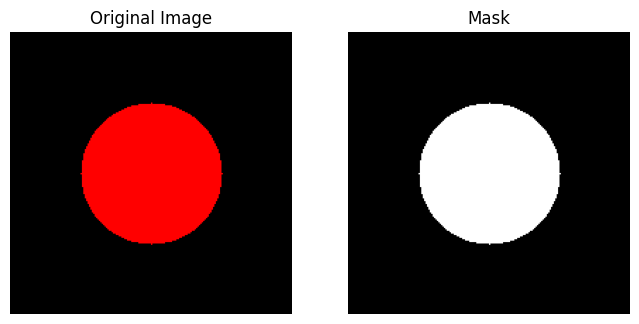

Contours found: 1
Contour center at (100, 100)


In [ ]:
# Apply our baseline threshold and show image vs mask side by side
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])
mask = cv2.inRange(hsv, lower_red, upper_red)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title('Original Image'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray'); plt.title('Mask'); plt.axis('off')
plt.show()

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Contours found:", len(contours))
if contours:
    M = cv2.moments(contours[0])
    cx = int(M['m10']/M['m00']) if M['m00']!=0 else None
    cy = int(M['m01']/M['m00']) if M['m00']!=0 else None
    print(f"Contour center at ({cx}, {cy})")
else:
    cx, cy = None, None

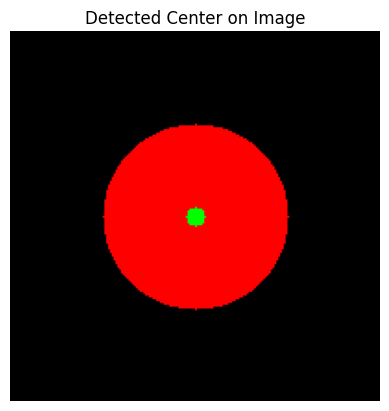

In [ ]:
# Show detected center on the image
image_marked = image.copy()
if cx is not None:
    cv2.circle(image_marked, (cx, cy), 5, (0,255,0), -1)
plt.imshow(cv2.cvtColor(image_marked, cv2.COLOR_BGR2RGB))
plt.title('Detected Center on Image')
plt.axis('off')
plt.show()

In [ ]:
# Map to world coordinates for this detection
image_h, image_w = image.shape[:2]
world_x = (cx/image_w)*plane_size - plane_size/2
world_y = (cy/image_h)*plane_size - plane_size/2
print(f"Mapped world coords: ({world_x:.2f}, {world_y:.2f})")

Mapped world coords: (0.00, 0.00)


In [ ]:
# Count masked pixels and try tighter threshold
print("Original mask pixel count:", np.sum(mask>0))
mask_tight = cv2.inRange(hsv, np.array([0, 150, 150]), np.array([10, 255, 255]))
print("Tight threshold mask count:", np.sum(mask_tight>0))

contours_t, _ = cv2.findContours(mask_tight, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Contours (tight):", len(contours_t))
if contours_t:
    M_t = cv2.moments(contours_t[0])
    cx_t = int(M_t['m10']/M_t['m00'])
    cy_t = int(M_t['m01']/M_t['m00'])
    print(f"Tight threshold center: ({cx_t}, {cy_t})")
else:
    cx_t, cy_t = None, None

Original mask pixel count: 7845
Tight threshold mask count: 7845
Contours (tight): 1
Tight threshold center: (100, 100)


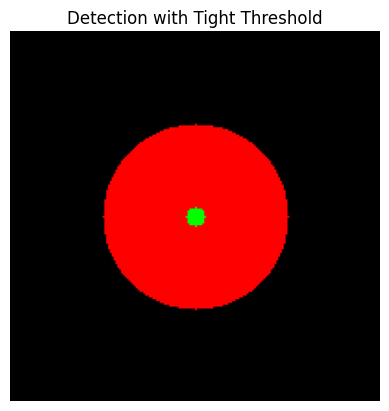

In [ ]:
# Display detection with tight threshold
image_tight = image.copy()
if cx_t is not None:
    cv2.circle(image_tight, (cx_t, cy_t), 5, (0,255,0), -1)
plt.imshow(cv2.cvtColor(image_tight, cv2.COLOR_BGR2RGB))
plt.title('Detection with Tight Threshold')
plt.axis('off')
plt.show()


In [ ]:
# Try a looser threshold (expand hue range) and evaluate
mask_loose = cv2.inRange(hsv, np.array([0, 50, 50]), np.array([20, 255, 255]))
print("Loose threshold mask count:", np.sum(mask_loose>0))

contours_l, _ = cv2.findContours(mask_loose, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Contours (loose):", len(contours_l))
if contours_l:
    M_l = cv2.moments(contours_l[0])
    cx_l = int(M_l['m10']/M_l['m00'])
    cy_l = int(M_l['m01']/M_l['m00'])
    print(f"Loose threshold center: ({cx_l}, {cy_l})")
else:
    cx_l, cy_l = None, None


Loose threshold mask count: 7845
Contours (loose): 1
Loose threshold center: (100, 100)


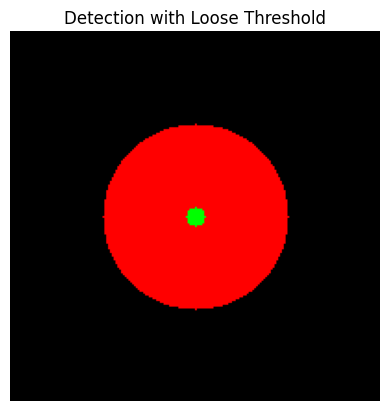

In [ ]:
# Display detection with loose threshold
image_loose = image.copy()
if contours_l:
    cv2.circle(image_loose, (cx_l, cy_l), 5, (0,255,0), -1)
plt.imshow(cv2.cvtColor(image_loose, cv2.COLOR_BGR2RGB))
plt.title('Detection with Loose Threshold')
plt.axis('off')
plt.show()

In [ ]:
# Compute pixel-center error compared to true center (100,100)
true_center = np.array([100, 100])
det_center = np.array([cx, cy])
pixel_error = np.linalg.norm(true_center - det_center)
true_world = np.array([0.0, 0.0])  # known mapping
det_world = np.array([world_x, world_y])
world_error = np.linalg.norm(true_world - det_world)
print(f"Pixel error: {pixel_error:.2f} px, World error: {world_error:.3f} m")

Pixel error: 0.00 px, World error: 0.000 m


In [ ]:
# Experiment: vary the hue lower bound and track error
errors = []
h_values = list(range(0, 31, 5))
for h in h_values:
    lower = np.array([h, 100, 100])
    upper = np.array([h+10, 255, 255])
    mask_tmp = cv2.inRange(hsv, lower, upper)
    contours_tmp, _ = cv2.findContours(mask_tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours_tmp:
        M_tmp = cv2.moments(contours_tmp[0])
        cx_tmp = int(M_tmp['m10']/M_tmp['m00'])
        cy_tmp = int(M_tmp['m01']/M_tmp['m00'])
        err = np.linalg.norm(true_center - np.array([cx_tmp, cy_tmp]))
        errors.append(err)
    else:
        errors.append(np.nan)
print("Hue lower bound vs pixel error:", list(zip(h_values, errors)))


Hue lower bound vs pixel error: [(0, np.float64(0.0)), (5, nan), (10, nan), (15, nan), (20, nan), (25, nan), (30, nan)]


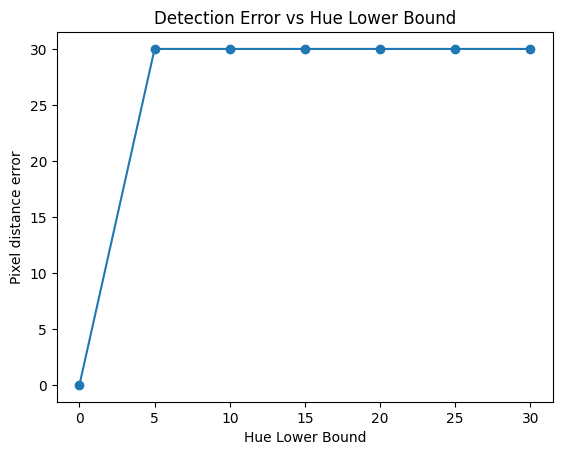

In [ ]:
# Plot error vs hue lower bound
plt.plot(h_values, [e if not np.isnan(e) else max(h_values) for e in errors], 'o-')
plt.title('Detection Error vs Hue Lower Bound')
plt.xlabel('Hue Lower Bound')
plt.ylabel('Pixel distance error')
plt.show()


🔍 **Debug Challenge**

**Goal:** Reduce pixel‑center error ⬇️ to **< 2 px** while keeping the mask free of noise.

1. Adjust `lower_red` / `upper_red` H‑S‑V values.  
2. Re‑run detection; print `pixel_error`.  
3. Plot a table of `(H_low, S_low, V_low) → pixel_error` for at least 5 combinations.  

🚀 Stretch

- Try **morphological operations** (`cv2.morphologyEx`) on the mask to remove speckle noise.  
- Measure how much processing time each additional debug print / plot adds; is it worth it?

**Mentor Discussion Prompts**:
- How did changing the HSV range affect the mask and detection?
- Did tightening the range reduce noise but risk missing the object?
- How does pixel error translate into world-coordinate error in meters?
- Why might the detected center shift even if the object is clearly visible? (Consider asymmetric lighting or contour shape.)
- How would you systematically choose HSV values for robust detection?